In [1]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [48]:
# @title import `matplotlib` `sklearn` and set defaults
# install packages to visualize brains and electrode locations

from matplotlib import rcParams
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import svm

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## SVM pipeline

In [49]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

print(alldat[1][0].keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [50]:
# @title select channels
electrode_indexes = []
electrode_indexes.append([])
electrode_indexes.append([])

for subject_index, subject in enumerate(alldat):
  electrode_indexes[0].append([])
  electrode_indexes[1].append([])
  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes[0][subject_index].append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes[1][subject_index].append(gyrus_index)

In [51]:
def get_data_label(sub_ID, roi_ID, condi_ID, time_ID):
  from scipy import signal

  dat = alldat[sub_ID][condi_ID] 

  ele_used = electrode_indexes[roi_ID][sub_ID]

  # filter the data
  # V is the voltage data
  V = dat['V'].astype('float32')
  V = V[:, ele_used]

  # low-pass filter below 200 Hz
  b, a = signal.butter(3, [200], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # high-pass filter above 1 Hz
  b, a = signal.butter(3, [1], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # average the broadband power across all tongue and hand trials
  nt, nchan = V.shape
  nstim = len(dat['t_on'])

  trange = np.arange(0, 2000)
  ts = dat['t_on'][:, np.newaxis]

  ts = ts + trange

  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

  data = V_epochs[:][:, time_ID][:]
  label = dat['stim_id']

  return data, label


In [52]:
# split data

# for example sub
# sub_ID : 0-6
# roi_ID : 0 precentral area; 1 postcentral area
# condi_ID : 0 actual; 1 imagery
# time_ID : 0-1999 time points, each time point can be used to train a classifier

data, label = get_data_label(sub_ID = 0, roi_ID = 0, condi_ID = 0, time_ID = 0)

train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size = 0.25)

# train the svm model

classifier = svm.SVC(C = 1, kernel = 'rbf', gamma = 10,  decision_function_shape = 'ovr')
classifier.fit(train_data, train_label)

print("training score: ", classifier.score(train_data, train_label))
# print("test score: ", classifier.score(test_data, test_label))

accuracies = cross_val_score(classifier, train_data, train_label, cv=8)  # k=8 cross validation


training score:  1.0


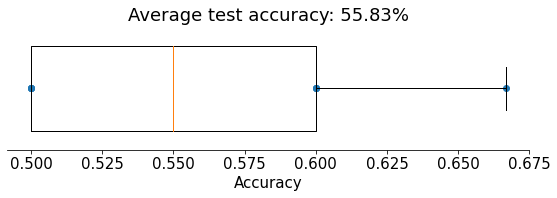

In [53]:
#@title
#@markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [54]:
# generalization
# train motor, generalization to imagery
gen_data, gen_label = get_data_label(sub_ID = 0, roi_ID  = 0, condi_ID = 1, time_ID = 0)


print("generalization score: ", classifier.score(gen_data, gen_label))

generalization score:  0.5
